(<Figure size 720x440 with 1 Axes>, <Axes: >)

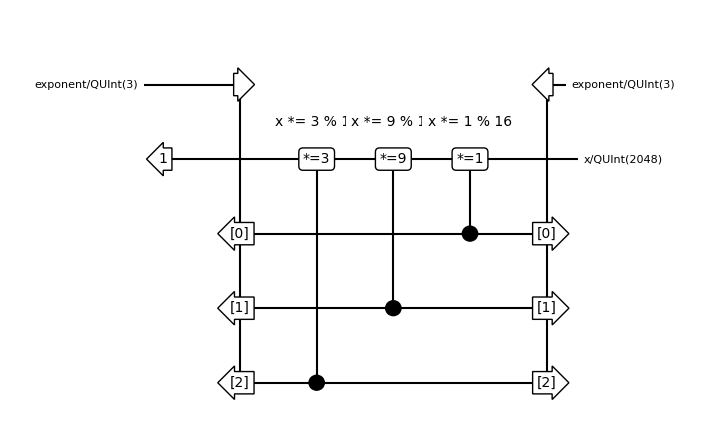

In [2]:
from qualtran.bloqs.factoring.mod_exp import ModExp
from qualtran.drawing import get_musical_score_data, draw_musical_score

modexp_small = ModExp(base=3, mod=16, exp_bitsize=3, x_bitsize=2048)
ms = get_musical_score_data(modexp_small.decompose_bloq())

draw_musical_score(ms)

In [ ]:
from dev_tools.qualtran_dev_tools.all_call_graph import get_all_call_graph
from dev_tools.qualtran_dev_tools.bloq_finder import get_bloq_examples

bes = get_bloq_examples()
g = get_all_call_graph(bes)

In [3]:
from sympy import Symbol
from typing import Any

from qualtran.drawing.musical_score import MusicalScoreEncoder
from qualtran._infra.registers import Side

class BloqEncoder(MusicalScoreEncoder):

  def default(self, o: Any) -> Any:
    if isinstance(o, (Symbol)):
      return f'Symbol({o})'
    if isinstance(o, complex):
      return f'{o.real}+{o.imag}i'
    if isinstance(o, Side):
      return 'Side.LEFT' if o == Side.LEFT else 'Side.RIGHT' if o == Side.RIGHT else 'Side.THRU'

    try:
      return super().default(o)
    except:
      return 'NOT_SERIALIZABLE'

In [17]:
import attrs
import hashlib

from qualtran import CompositeBloq
from qualtran.bloqs.rotations.programmable_rotation_gate_array import ProgrammableRotationGateArray

def bloq_attrs(bloq):
  if isinstance(bloq, CompositeBloq):
    return {}
  if isinstance(bloq, ProgrammableRotationGateArray):
    return {}

  return attrs.asdict(bloq)

def bloq_filename(bloq):
  unhashed = json.dumps(bloq_attrs(bloq), cls=BloqEncoder)

  return hashlib.md5(unhashed.encode(), usedforsecurity=False).hexdigest() + '.json'

In [21]:
import json
from pathlib import Path

from qualtran_dev_tools.notebook_specs import NB_BY_SECTION

docs_by_section = {
  section[0]: {
    notebook_spec.title: list(
      {
        'name': bloq_spec.bloq_cls.__name__,
        'examples': list(
          {
            'name': example.name,
            'filename': bloq_filename(example.make())
          }
          for example in bloq_spec.examples
        )
      }
      for bloq_spec in notebook_spec.bloq_specs
    )
    for notebook_spec in section[1]
  }
  for section in NB_BY_SECTION
}

Path('ui_export').mkdir(parents=True, exist_ok=True)

with open('ui_export/navigation.json', 'w') as f:
  json.dump(docs_by_section, f, indent=2)

In [23]:
import json
import os
from pathlib import Path

from qualtran_dev_tools.notebook_specs import NB_BY_SECTION
from qualtran_dev_tools.parse_docstrings import get_markdown_docstring_lines
from qualtran.drawing.musical_score import get_musical_score_data

def bloq_score(bloq):
  try:
    return get_musical_score_data(bloq.decompose_bloq())
  except:
    return None

def write_example(bloq):
  call_graph, _ = bloq.call_graph(max_depth=1)

  for child_bloq, _ in call_graph.succ[bloq].items():
    write_example(child_bloq)

  Path(f'ui_export/{bloq.__class__.__name__}').mkdir(parents=True, exist_ok=True)

  doc_name = f'ui_export/{bloq.__class__.__name__}/docs.txt'
  if not os.path.isfile(doc_name):
    with open(doc_name, 'w') as doc_file:
      doc_file.write('\n'.join(get_markdown_docstring_lines(bloq.__class__)))

  file_name = f'ui_export/{bloq.__class__.__name__}/{bloq_filename(bloq)}'
  if not os.path.isfile(file_name):
    bloq_dict = {
      'name': bloq.__class__.__name__,
      'attrs': bloq_attrs(bloq),
      'score': bloq_score(bloq),
      'callees': list(
        {
          'name': child_bloq.__class__.__name__,
          'filename': bloq_filename(child_bloq)
        }
        for child_bloq, _ in call_graph.succ[bloq].items()
      )
    }

    with open(file_name, 'w') as f:
      json.dump(bloq_dict, f, indent=2, cls=BloqEncoder)

for section in NB_BY_SECTION:
  for notebook_spec in section[1]:
    for bloq_spec in notebook_spec.bloq_specs:
      for example in bloq_spec.examples:
        write_example(example.make())